## 공통

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split

np.random.seed(0)

## 데이터 정리

In [2]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
# finger_data 폴더에서 다운로드
tv_x = np.load('/content/drive/My Drive/train_x.npy')
tv_y = np.load('/content/drive/My Drive/train_y.npy')

# sequence length
length = tv_x.shape[1]
# dimension
dim = tv_x.shape[2]

train_x, test_x, train_y, test_y = train_test_split(tv_x, tv_y, test_size=0.4, random_state=0)
train_x, validation_x, train_y, validation_y = train_test_split(train_x, train_y, test_size=0.5, random_state=0)

In [4]:
print(length)
print(dim)

50
28


In [5]:
# augmenting functions
def jitter(x, y, n_jitter):
  js = np.random.choice(len(x), size=n_jitter)

  jittered_arr = np.empty((n_jitter, length, dim))
  answer_arr = np.empty(n_jitter)
  jitter_original_arr = np.empty((n_jitter, length, dim))

  for i in range(len(js)):
    ji = js[i]
    data = x[ji]

    j = np.random.normal(scale=2, size=(length, dim))
    jittered = data + j

    jittered_arr[i] = jittered
    answer_arr[i] = y[ji]
    jitter_original_arr[i] = data

  return jittered_arr, answer_arr, jitter_original_arr

def scale(x, y, n_scale):
  ss = np.random.choice(len(x), size=n_scale)

  scaled_arr = np.empty((n_scale, length, dim))
  answer_arr = np.empty(n_scale)
  scale_original_arr = np.empty((n_scale, length, dim))

  for i in range(len(ss)):
    si = ss[i]
    data = x[si]

    s = np.random.normal(loc=1, scale=0.015, size=(1, dim))
    scaled = data * s

    scaled_arr[i] = scaled
    answer_arr[i] = y[si]
    scale_original_arr[i] = data

  return scaled_arr, answer_arr, scale_original_arr

In [6]:
n_jitter = 10 * train_x.shape[0]

augmented_x = np.empty((train_x.shape[0] + n_jitter, train_x.shape[1], train_x.shape[2]))
augmented_y = np.empty(train_x.shape[0] + n_jitter)

for i in range(len(train_x)):
  augmented_x[i] = train_x[i]
  augmented_y[i] = train_y[i]

jittered_x, jittered_y, _ = jitter(train_x, train_y, n_jitter)

for i in range(n_jitter):
  augmented_x[i+len(train_x)] = jittered_x[i]
  augmented_y[i+len(train_x)] = jittered_y[i]

In [7]:
augmented_y = np.reshape(augmented_y, (-1, 1))
validation_y = np.reshape(validation_y, (-1, 1))
test_y = np.reshape(test_y, (-1, 1))

# 94 -> 1034
for data in [augmented_x, augmented_y, validation_x, validation_y, test_x, test_y]:
    print(data.shape)

(1034, 50, 28)
(1034, 1)
(95, 50, 28)
(95, 1)
(127, 50, 28)
(127, 1)


In [8]:
batch_size = 128
lr = 5e-3
num_epochs = 300
weight_decay = 0
dropout = 0.95
hidden_size = 8
num_layers = 2

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device,'is ready')

path = 'model.pt'

cuda:0 is ready


In [9]:
def to_dataloader(x, y):
  x_tensor = torch.Tensor(x).to(device) # transform to torch tensor
  y_tensor = torch.Tensor(y).to(device)

  dataset = TensorDataset(x_tensor, y_tensor) # create your datset
  return DataLoader(dataset, batch_size=batch_size) # create your dataloader

In [10]:
# GRU
class GRU(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, device):
    super(GRU, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    self.d = 1

    self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=False).to(self.device)
    self.bn = nn.BatchNorm1d(self.d * hidden_size).to(self.device)
    self.fc = nn.Sequential(nn.Linear(self.d * hidden_size, 1), nn.Sigmoid()).to(self.device)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers*self.d, x.size()[0], self.hidden_size).to(self.device) # 초기 hidden state
    
    out, _ = self.gru(x, h0)
    out = out[:,-1]

    # normalization + layering
    out = self.fc(
        self.bn(out)
      )
    return out

In [11]:
# dim=28, hidden_size=8, num_layers=2
model = GRU(dim, hidden_size, num_layers, device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [22]:
# RETAIN
class RETAIN(nn.Module):
  def __init__(self, input_size, visit_hidden_size, var_hidden_size, visit_num_layers, var_num_layers, var_attn_output_size, output_dropout, device):
    super(RETAIN, self).__init__()
    # basic setting
    self.device = device
    self.visit_hidden_size = visit_hidden_size
    self.var_hidden_size = var_hidden_size
    self.visit_num_layers = visit_num_layers
    self.var_num_layers = var_num_layers
    self.output_dropout = nn.Dropout(output_dropout)
    self.visit_attn_output_size = 1
    self.d = 1

    # embedding
    self.embed_layer = nn.Linear(self.d * input_size, visit_hidden_size).to(self.device)

    self.visit_rnn = nn.GRU(input_size, visit_hidden_size, visit_num_layers, batch_first=True, dropout=dropout, bidirectional=False).to(self.device)
    self.visit_level_attention = nn.Linear(self.d * visit_hidden_size, self.visit_attn_output_size).to(self.device)

    self.var_rnn = nn.GRU(input_size, var_hidden_size, var_num_layers, batch_first=True, dropout=dropout, bidirectional=False).to(self.device)
    self.variable_level_attention = nn.Linear(self.d * var_hidden_size, var_attn_output_size).to(self.device)

    self.output_layer = nn.Linear(64, 1)


  def forward(self, x):
    h0_visit = torch.zeros(self.visit_num_layers*self.d, x.size()[0], self.visit_hidden_size).to(self.device)
    visit_rnn_output, _ = self.visit_rnn(torch.flip(x, [0]), h0_visit) # in reverse order
    alpha = self.visit_level_attention(torch.flip(visit_rnn_output, [0])) # α (scalar)
    visit_attn_w = F.softmax(alpha, dim=0)

    h0_var = torch.zeros(self.var_num_layers*self.d, x.size()[0], self.var_hidden_size).to(self.device)
    var_rnn_output, _ = self.var_rnn(torch.flip(x, [0]), h0_var) # in reverse order
    beta = self.variable_level_attention(torch.flip(var_rnn_output, [0])) # β (vector)
    var_attn_w = torch.tanh(beta)

    attn_w = visit_attn_w * var_attn_w
    emb_x = self.embed_layer(x)
    # 여기서 망하네
    c = torch.sum(attn_w * emb_x, dim=1)
    c = self.output_dropout(c)

    output = self.output_layer(c)
    output = F.softmax(output, dim=1)
    
    return output
  
# dim=28, hidden_size=8, num_layers=2
model = RETAIN(dim, 64, 64, 2, 2, 64, 0.95, device).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

epoch: 30


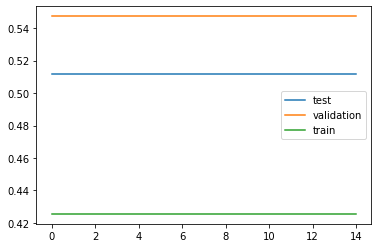

epoch: 60


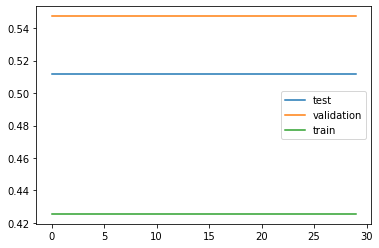

KeyboardInterrupt: ignored

In [23]:
# model
train_dataloader = to_dataloader(augmented_x, augmented_y)
validation_dataloader = to_dataloader(validation_x, validation_y)
test_dataloader = to_dataloader(test_x, test_y)
running_loss = []

test_acc = []
val_acc = []
train_acc = []

best_acc = -1

for epoch in range(num_epochs):
  if (epoch % 30 == 0 and epoch!=0) or epoch==299:
    print('epoch: {}'.format(epoch))
    plt.plot(test_acc)
    plt.plot(val_acc)
    plt.plot(train_acc)
    plt.legend(['test', 'validation', 'train'])
    plt.show()
  
  # train mode
  model.train()

  for seq, target in train_dataloader:
    out = model(seq)
    loss = criterion(out, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss.append(loss.item())
  
  # eval mode
  model.eval()

  if epoch % 2 == 0:
    val_correct = 0
    train_correct = 0
    test_correct = 0

    with torch.no_grad():
      for seq, target in test_dataloader:
        out = model(seq)
        # classification
        result = (out > 0.5).float()*1
        test_correct += torch.sum(result == target).data

      for seq, target in validation_dataloader:
        out = model(seq)
        result = (out > 0.5).float()*1
        val_correct += torch.sum(result == target).data

      for seq, target in train_dataloader:
        out = model(seq)
        result = (out > 0.5).float()*1
        train_correct += torch.sum(result == target).data

      test_acc.append(test_correct / len(test_x))

      va = val_correct / len(validation_x)

      val_acc.append(va)
      train_acc.append(train_correct / len(augmented_x))

      # saving best model
      if va > best_acc:
        best_acc = va

        torch.save(model, path)


best: tensor(0.5158, device='cuda:0')
loss graph:


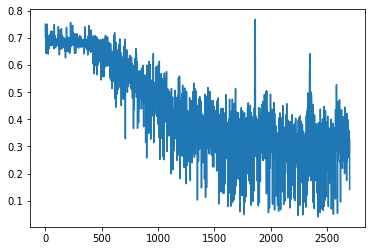

accuracy graph:


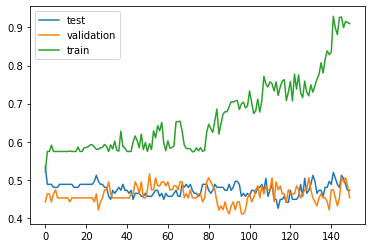

In [ ]:
print("best:", best_acc)

print('loss graph:')
plt.plot(running_loss)
plt.show()

print('accuracy graph:')
plt.plot(test_acc)
plt.plot(val_acc)
plt.plot(train_acc)
plt.legend(['test', 'validation', 'train'])
plt.show()

correct = 0

with torch.no_grad():
  model = torch.load(path)

  model.eval()

  for seq, target in test_dataloader:
    out = model(seq)
    result = (out > 0.5).float()*1.0
    correct += torch.sum(result == target).data

print()
# print(correct / len(test_x))

## Basic data augmentation

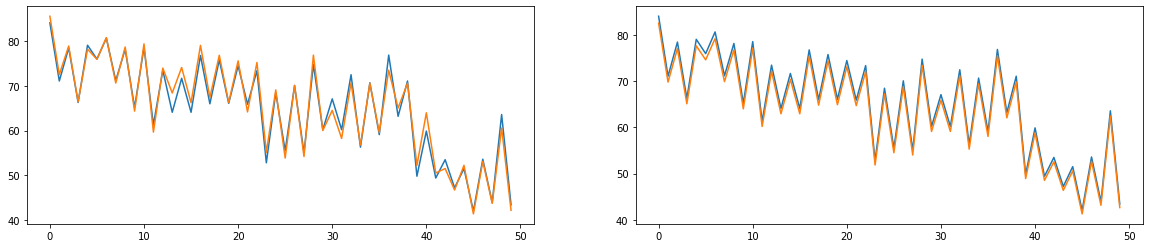

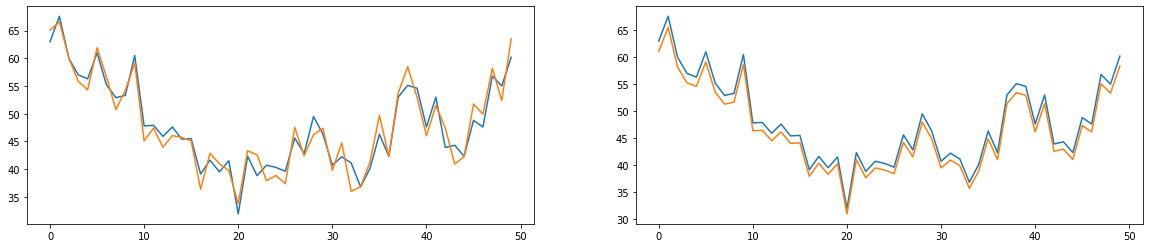

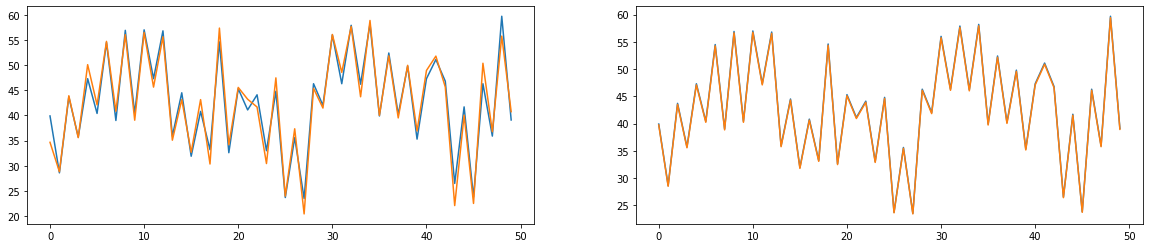

In [ ]:
# Visualize jittering and scaling

for i in [0, 1, 2]:
  data = train_x[i,:,0]
  size = len(data)

  n = np.random.normal(scale=2, size=size)
  jittered = data + n

  s = np.random.normal(loc=1, scale=0.02)
  scaled = data * s

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
  ax1.plot(data)
  ax1.plot(jittered)
  ax2.plot(data)
  ax2.plot(scaled)
  plt.show()

In [ ]:
# Create new dataset with basic data augmentation

def jitter(dataset, n_jitter):
  js = np.random.choice(len(dataset), size=n_jitter)

  jittered_arr = np.empty((n_jitter, length, dim))
  jitter_original_arr = np.empty((n_jitter, length, dim))

  for i in range(len(js)):
    ji = js[i]
    data = dataset[ji]

    size = len(data)

    j = np.random.normal(scale=2, size=(length, dim))
    jittered = data + j

    jittered_arr[i] = jittered
    jitter_original_arr[i] = data

  return jittered_arr, jitter_original_arr

def scale(dataset, n_scale):
  ss = np.random.choice(len(dataset), size=n_scale)

  scaled_arr = np.empty((n_scale, length, dim))
  scale_original_arr = np.empty((n_scale, length, dim))

  for i in range(len(ss)):
    si = ss[i]
    data = dataset[si]

    size = len(data)

    s = np.random.normal(loc=1, scale=0.015, size=(1, dim))
    scaled = data * s

    scaled_arr[i] = scaled
    scale_original_arr[i] = data

  return scaled_arr, scale_original_arr


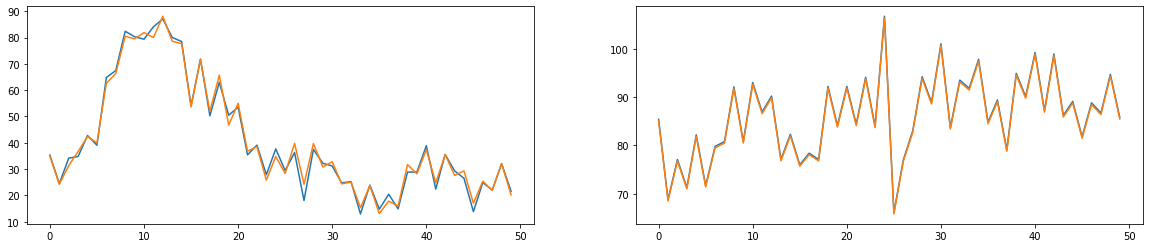

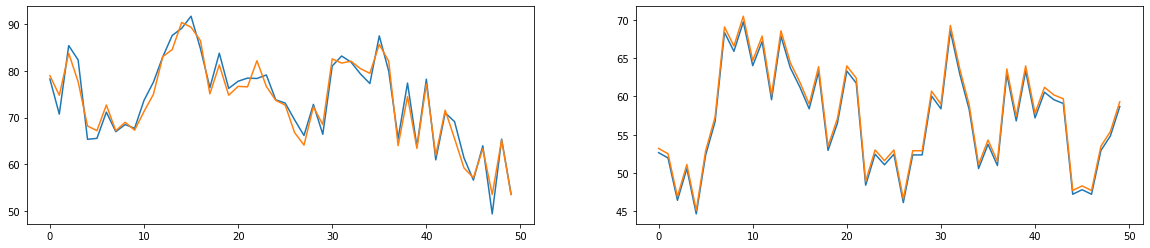

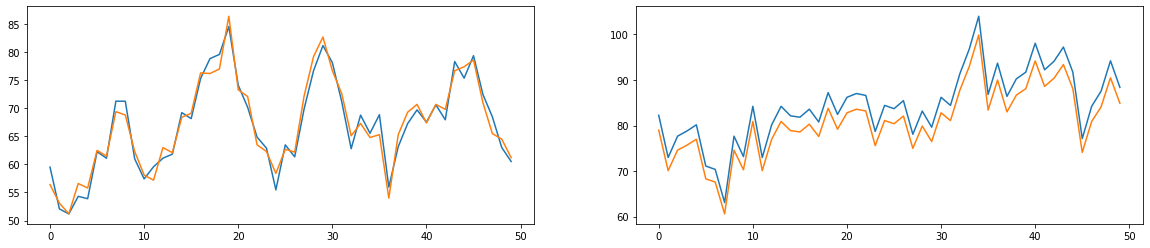

In [ ]:
n_jitter = 5
n_scale = 5

jittered_arr, jitter_original_arr = jitter(train_x, n_jitter)
scaled_arr, scale_original_arr = scale(train_x, n_scale)

for i in [0, 1, 2]:
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
  ax1.plot(jittered_arr[i,:,0])
  ax1.plot(jitter_original_arr[i,:,0])
  ax2.plot(scaled_arr[i,:,0])
  ax2.plot(scale_original_arr[i,:,0])
  plt.show()

## GAN data augmentation

## Basic RNN

## Attention-based RNN

## 결과 종합